In [1]:
import os
import pickle
from typing import List

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from mne.channels import make_standard_montage
from mne.decoding import CSP
from numpy import ndarray
from pandas import DataFrame
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import ShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

mne.set_log_level(verbose=False)

# Load Data

Select between ADI and AVI

In [2]:
ADI = 0
AVI = 1
example = AVI

if example == ADI:
    subject = 'adi'
    session_id = '6'
    num_channels = 16

if example == AVI:
    subject = 'avi'
    session_id = '4'
    num_channels = 13

recordings_path = '..\\..\\recordings'
labels_path = os.path.join(recordings_path, subject, session_id, 'labels.csv')
trials_path = os.path.join(recordings_path, subject, session_id, 'trials.pickle')

# load data
labels = pd.read_csv(labels_path, header=None).to_numpy().squeeze()
trials: List[DataFrame] = pickle.load(open(trials_path, 'rb'))

# trim trials
trials = [trial.iloc[:, :num_channels] for trial in trials]

# convert data to mne.Raw
ch_names = list(trials[0].columns)
ch_types = ['eeg'] * len(ch_names)
sfreq = 120

n_samples = min([t.shape[0] for t in trials])

epochs_array: ndarray = np.stack([df[:n_samples].to_numpy().T for df in trials])

info = mne.create_info(ch_names, sfreq, ch_types)
epochs = mne.EpochsArray(epochs_array, info)

# set montage
montage = make_standard_montage('standard_1020')
epochs.set_montage(montage)

<EpochsArray |  120 events (all good), 0 - 3.7 sec, baseline off, ~5.3 MB, data loaded,
 '1': 120>

# Raw Data
(ignore the topomap)

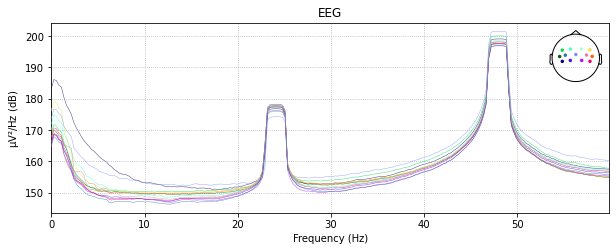

In [3]:
epochs.plot_psd();

# Processed Data

Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 199 samples (1.658 sec)



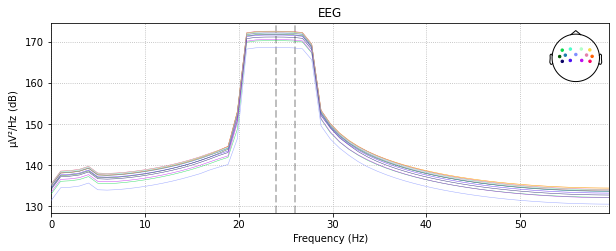

In [4]:
# Apply band-pass filter
epochs.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=True)

# apply notch filter at 25
epochs.filter(24, 26, fir_design='firwin', skip_by_annotation='edge')

epochs_train = epochs.copy().crop(tmin=0.5, tmax=1.5)
epochs_train.plot_psd();

# Classification with CSP & LDA

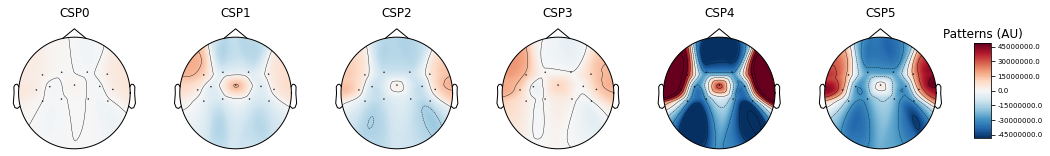

In [5]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = StratifiedKFold(4, shuffle=True, random_state=42)
cv_split = cv.split(epochs_data_train, labels)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1, verbose=False)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5);

# Look at performance over time

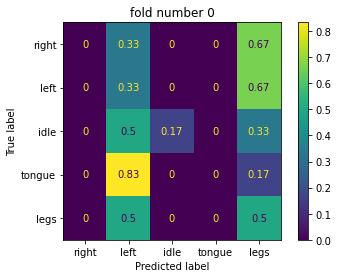

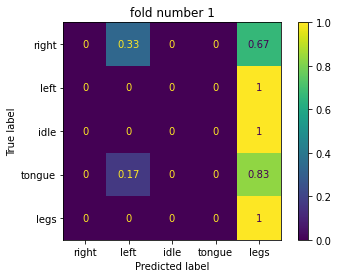

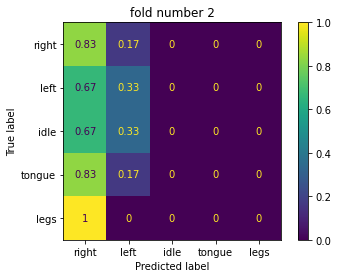

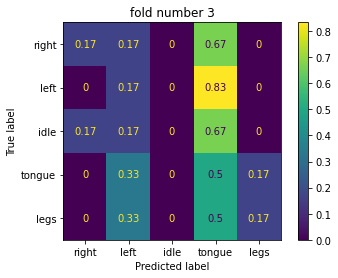

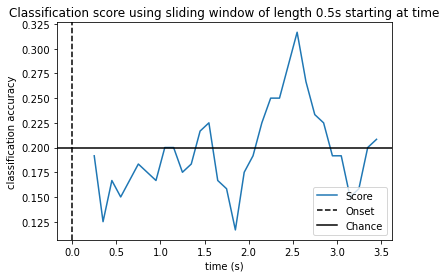

In [6]:
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for idx, (train_idx, test_idx) in enumerate(cv_split):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

    # print confusion matrix
    try:
        label_names = ['right', 'left', 'idle', 'tongue', 'legs']
        y_pred = lda.predict(X_test)
        plot_confusion_matrix(lda, X_test, y_test, normalize='true', display_labels=label_names)
        plt.title(f"fold number {idx}")
        plt.show()
    except ValueError as e:
        pass

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.2, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score using sliding window of length 0.5s starting at time')
plt.legend(loc='lower right')
plt.show()




# todo: continue here
# why recordings/adi/7 different lengths? (are they online??)
# why are recordings/adi/6 different lengths (sometimes 4, sometimes 4.5 secs)
# expose full_scr to main script
# add metadata: datetime, offline/online
# control all trials to be same sample length
# keep track of recordings
# write a recordings schedule
# set recordings_folder initial_dir
# incremental LDA